In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/My\ Drive/DS440/ # connect to google drive to get the basketball court image file stored in DS440 folder and look at the content of the folder in Google Drive to make sure the image is in the folder

Mounted at /content/drive
 basketball_court_half.png  'DS 440 project environment setup.ipynb'


In [2]:
path="/content/drive/My Drive/DS440/basketball_court_half.png" # change the path to path that stores the basketball court image

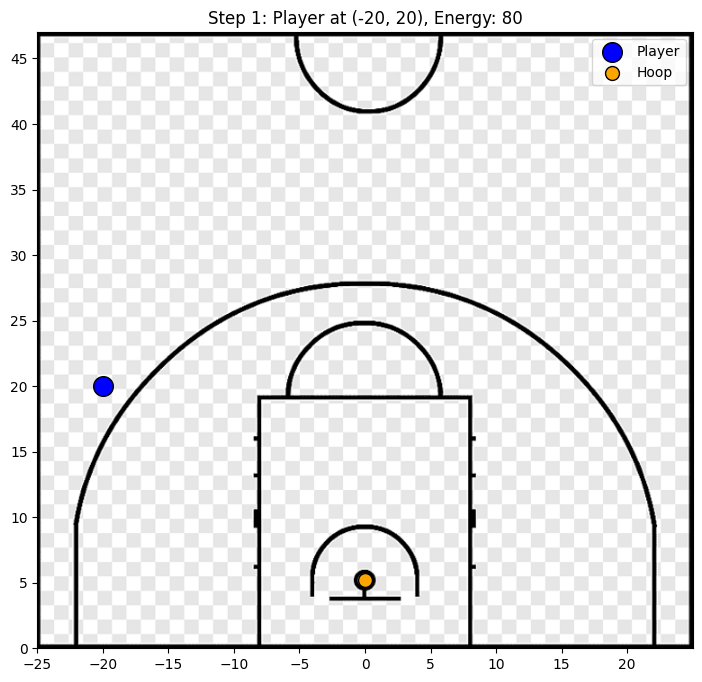

Reward Test:
Shooting from (-20, 20): 15
Shooting from (0, 2): -5
Distance from the hoop (x,y): 3.2
FG made percentage from (x,y): 0.545
Shooting from (10, 43): -5


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

# Load the basketball court image from the uploaded file
court_img = mpimg.imread(path)

def distance_from_hoop(x, y):
    """Calculate the distance from the player to the hoop at (0, 5.2)."""
    return math.sqrt((x ** 2) + ((y - 5.2)** 2))

def calculate_success_prob(dist):
    """Calculate success probability based on distance."""

    if dist <= 23.75:
        base_prob = 0.545  # 54.5% success probability for two-pointers
    else:
        base_prob = 0.353  # 35.3% success probability for three-pointers

    reduction = 0.0 #initialize reduction

    # Apply 1% reduction for each foot between 23.75 and 30 feet
    if 23.75 <= dist <= 30:
        reduction = (dist - 23.75) * 0.01  # 1% reduction per foot
    # Apply 10% reduction for each foot beyond 30 feet
    elif dist > 30:
        reduction = (30 - 23.75) * 0.01 + ((dist - 30)// 3 ) * 0.1  # Combined reduction

    # Ensure the probability doesn't drop below 1%
    return max(0.01, base_prob - reduction)

def reward(action, state):
    """Simulate the reward with step-wise penalty and reduced success probability."""
    x, y, energy = state

    if action == "shoot":
        dist = distance_from_hoop(x, y)

        # Calculate penalty for every 3 feet beyond 23.75 feet
        penalty_steps = max(0, (dist - 23.75) // 3)
        penalty = penalty_steps * 1  # 1 point penalty per step

        # Apply three-point or two-point logic based on distance
        if dist > 23.75:
            reward_value = 15 # Base reward for a three-pointer
        else:
            reward_value = 10 # Base reward for a two-pointer

        # Apply the penalty to the reward
        final_reward = reward_value - penalty

        # Calculate dynamic success probability
        success_prob = calculate_success_prob(dist)

        # Determine if the shot is successful
        return final_reward if np.random.random() < success_prob else -5  # Missed shot penalty

    elif action == "pass":
        return 5  # Safe action with a moderate reward
    elif action == "drive" and energy >= 30:
        return 8 if np.random.random() < 0.7 else -3  # Driving to the basket

    return -10  # Penalty for invalid actions or insufficient energy


def display_player_and_hoop(state, step):
    """Display the player and hoop on the court."""
    x, y, energy = state

    plt.figure(figsize=(12, 8))
    plt.imshow(court_img, extent=[-25, 25, 0 , 47])

    # Plot the player position
    plt.scatter(x, y, color='blue', s=200, marker='o', edgecolors='black', label='Player')

    # Plot the hoop at (0, 5.2) with a size of 100, court size in nba is 47 feet long and 50 feet wide
    plt.scatter(0, 5.2, color='orange', s=100, marker='o', edgecolors='black', label='Hoop')

    # Set axis limits and orientation
    plt.xlim(-25, 25)
    plt.ylim(0, 47)

    plt.title(f"Step {step + 1}: Player at ({x}, {y}), Energy: {energy}")
    plt.xticks(np.arange(-25, 25, 5))  # Adjust ticks to match the court size
    plt.yticks(np.arange(0, 47, 5))  # Adjust y-axis ticks
    plt.legend(loc='upper right')
    plt.show()

# Example test to visualize the player and hoop with the new coordinates
test_state_1 = (-20, 20, 80)  # Initial state of the player

# Visualize the player and hoop for one step
display_player_and_hoop(test_state_1, step=0)

# Test the reward function with various positions
print("Reward Test:")
print(f"Shooting from (-20, 20): {reward('shoot', (-20, 20, 80))}")  # Should be a 3-pointer
print(f"Shooting from (0, 2): {reward('shoot', (0, 2, 80))}") # Should be a 2-pointer
print(f"Distance from the hoop (x,y): {distance_from_hoop(0,2)}")
print(f"FG made percentage from (x,y): {calculate_success_prob(distance_from_hoop(0,2))}")
print(f"Shooting from (10, 43): {reward('shoot', (10, 43, 80))}")  #should be missed FG